In [ ]:
import pandas as pd

# === Step 1: Load the raw hero network data ===
file_path = "Datas/hero-network.csv"
df = pd.read_csv(file_path)

# === Step 2: Normalize character pairs so that (A, B) and (B, A) are treated the same ===
# This ensures the network is undirected
df[["hero1", "hero2"]] = df[["hero1", "hero2"]].apply(sorted, axis=1, result_type='expand')

# === Step 3: Group by each unique hero pair and count occurrences ===
# This count becomes the weight (number of co-appearances)
df_weighted = df.groupby(["hero1", "hero2"]).size().reset_index(name="weight")

# === Step 4: Save the processed data to a new CSV file ===
output_path = "Datas_Clean/hero-network-weighted.csv"
df_weighted.to_csv(output_path, index=False)

print(f"Weighted hero network saved to '{output_path}' with {len(df_weighted)} unique connections.")


Weighted hero network saved to 'hero-network-weighted.csv' with 167219 unique connections.


In [9]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load the pre-processed hero network with co-appearance weights ===
# This file contains hero pairs with their co-appearance counts as weights
df_edges = pd.read_csv("Datas_Clean/hero-network-weighted.csv")
df_edges.columns = ['source', 'target', 'weight']  # Rename columns for clarity

# === Step 2: Create an undirected graph using NetworkX ===
# We treat each hero as a node and each co-appearance as an edge with a weight
G = nx.Graph()
for _, row in df_edges.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['weight'])

# === Step 3: Print basic graph statistics ===
print(f"Total nodes (unique heroes): {G.number_of_nodes()}")
print(f"Total edges (unique hero pairs): {G.number_of_edges()}")


Total nodes (unique heroes): 6426
Total edges (unique hero pairs): 167219


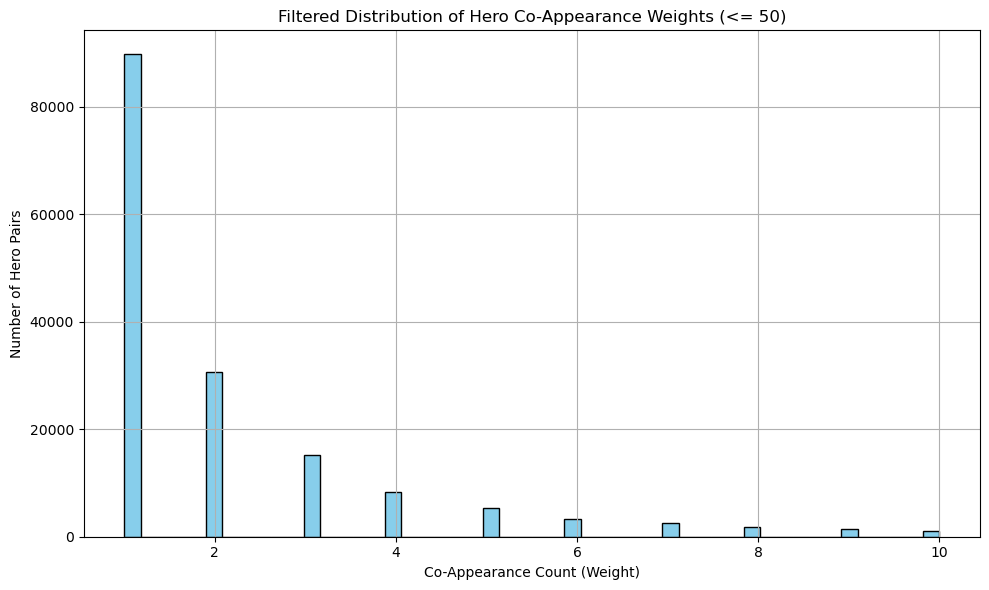

In [ ]:
# === Step 4: Visualize the distribution of edge weights ===
# This shows how frequently different hero pairs co-appeared
# Filter out extreme outliers for better visualization
filtered = df_weighted[df_weighted['weight'] <= 10]

# Plot histogram of edge weights (co-appearance counts)
plt.figure(figsize=(10, 6))
plt.hist(filtered['weight'], bins=50, color='skyblue', edgecolor='black')
plt.title("Filtered Distribution of Hero Co-Appearance Weights (<= 50)")
plt.xlabel("Co-Appearance Count (Weight)")
plt.ylabel("Number of Hero Pairs")
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
# === Step 5: Build the full weighted graph from the filtered edge list ===
G = nx.Graph()
for _, row in df_weighted.iterrows():
    G.add_edge(row['hero1'], row['hero2'], weight=row['weight'])

print(f"Total nodes in full graph: {G.number_of_nodes()}")
print(f"Total edges in full graph: {G.number_of_edges()}")

# === Step 3: Apply Island Method to filter strong connections ===
# Keep only edges with weight >= 3
threshold = 3
G_island = nx.Graph((u, v, d) for u, v, d in G.edges(data=True) if d['weight'] >= threshold)

print(f"Nodes in island graph (weight ≥ {threshold}): {G_island.number_of_nodes()}")
print(f"Edges in island graph (weight ≥ {threshold}): {G_island.number_of_edges()}")

# === Step 6: Remove isolated nodes (nodes with no remaining edges) ===
isolates = list(nx.isolates(G_island))
G_island.remove_nodes_from(isolates)

print(f"Nodes after removing isolates: {G_island.number_of_nodes()}")


Total nodes in full graph: 6426
Total edges in full graph: 167219
Nodes in island graph (weight ≥ 3): 3504
Edges in island graph (weight ≥ 3): 46867
Nodes after removing isolates: 3504


In [39]:
# === Step 7: Load Node metadata (character group information) ===
nodes_path = "Datas_Clean/nodes.csv"
if os.path.exists(nodes_path):
    df_nodes = pd.read_csv(nodes_path)
    df_nodes.columns = [col.lower() for col in df_nodes.columns]
    node_groups = dict(zip(df_nodes['node'], df_nodes.get('type', ['Unknown'] * len(df_nodes))))
else:
    print("Nodes metadata file not found! Proceeding without groups.")
    node_groups = {}

# Set node attributes for graph
nx.set_node_attributes(G_island, {node: {'group': node_groups.get(node, 'Unknown')} for node in G_island.nodes()})

In [40]:
# === Step 8: Compute centrality measures on island graph ===
degree_centrality = nx.degree_centrality(G_island)
betweenness_centrality = nx.betweenness_centrality(G_island, weight='weight')
eigenvector_centrality = nx.eigenvector_centrality(G_island, max_iter=1000, weight='weight')

# Create centrality dataframe 
centrality_df = pd.DataFrame({
    "character": list(G_island.nodes()),
    "degree_centrality": [degree_centrality[node] for node in G_island.nodes()],
    "betweenness_centrality": [betweenness_centrality[node] for node in G_island.nodes()],
    "eigenvector_centrality": [eigenvector_centrality[node] for node in G_island.nodes()]
})

In [43]:
# === Step 9: Select Top 100 Most Connected Characters ===
top_100_df = centrality_df.sort_values(by='degree_centrality', ascending=False).head(100)
top_100_nodes = top_100_df['character'].tolist()

# === Step 10: Build subgraph of top 100 characters ===
G_top100 = G_island.subgraph(top_100_nodes).copy()

# === Step 11: Load group/type metadata and assign to top 100 graph ===
df_meta = pd.read_csv("Datas_Clean/Character_Classification.csv")
df_meta.columns = df_meta.columns.str.lower()  # 'character', 'group', 'type'

# Add attributes to G_top100
for _, row in df_meta.iterrows():
    char = row['character']
    if G_top100.has_node(char):
        G_top100.nodes[char]['group'] = row['group']
        G_top100.nodes[char]['type'] = row['type']

print("Example node with metadata:")
for n, d in list(G_top100.nodes(data=True))[:10]:
    print(n, d)

Example node with metadata:
INVISIBLE WOMAN/SUE  {'group': 'Fantastic Four', 'type': 'Hero'}
JONES, RICHARD MILHO {'group': 'Independent', 'type': 'Neutral'}
BEAST/HENRY &HANK& P {'group': 'X-Men', 'type': 'Hero'}
PUNISHER II/FRANK CA {'group': 'Independent', 'type': 'Anti-Hero'}
SCARLET WITCH/WANDA  {'group': 'Avengers', 'type': 'Hero'}
BANSHEE/SEAN CASSIDY {'group': 'X-Men', 'type': 'Hero'}
JAMESON, J. JONAH {'group': 'Independent', 'type': 'Neutral'}
ANGEL/WARREN KENNETH {'group': 'X-Men', 'type': 'Hero'}
PSYLOCKE/ELISABETH B {'group': 'X-Men', 'type': 'Hero'}
MOCKINGBIRD/DR. BARB {'group': 'Avengers', 'type': 'Hero'}


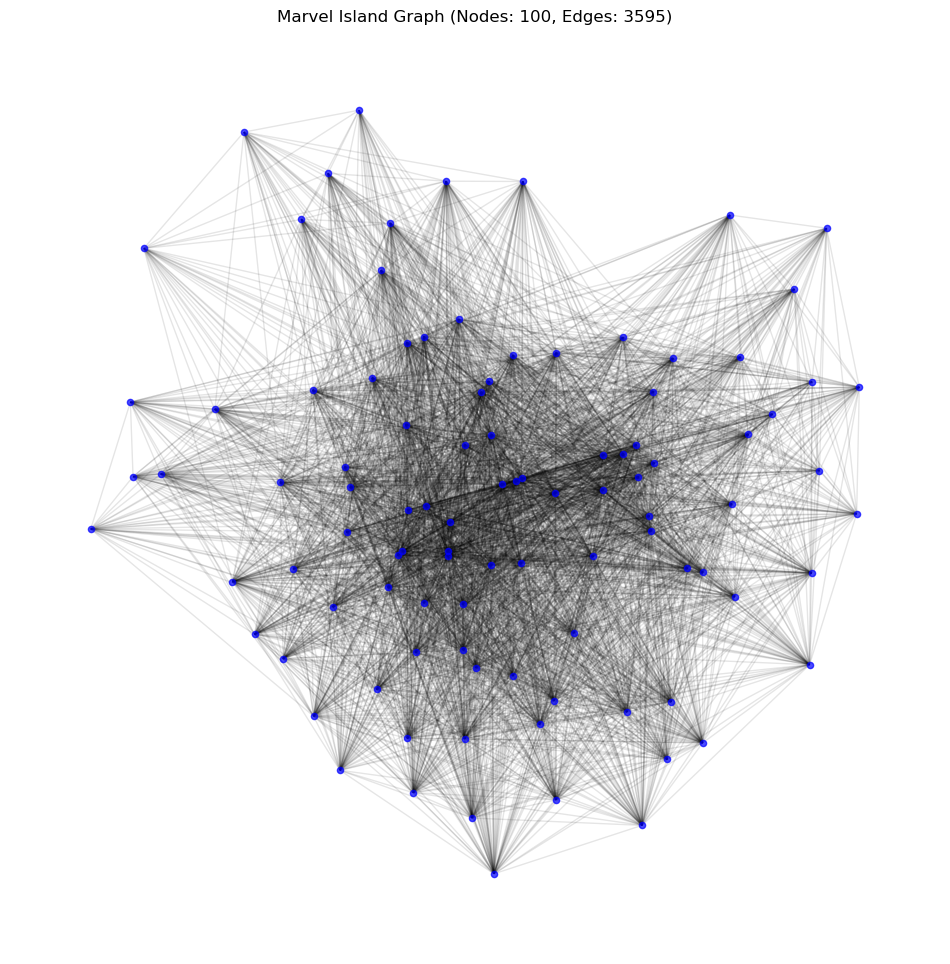

In [44]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G_top100, k=0.15, seed=42, weight='weight')

nx.draw_networkx_nodes(G_top100, pos, node_size=20, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(G_top100, pos, alpha=0.1)

plt.title(f"Marvel Island Graph (Nodes: {G_top100.number_of_nodes()}, Edges: {G_top100.number_of_edges()})")
plt.axis('off')
plt.show()

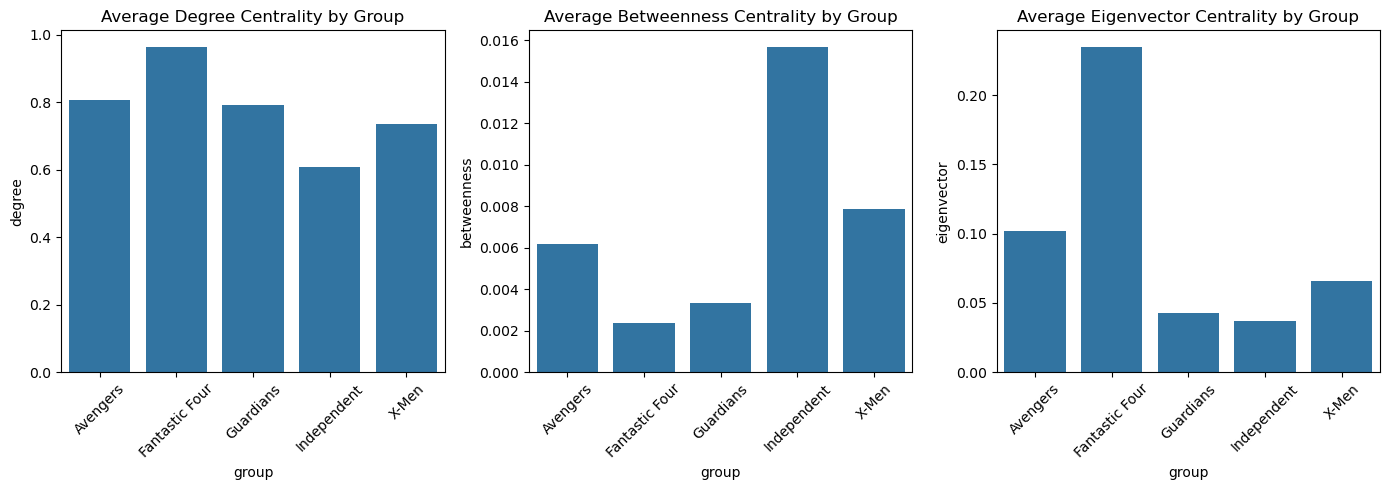

In [46]:


# Extract node attributes and compute centralities
data = []
# Compute centralities only once
degree_centrality = nx.degree_centrality(G_top100)
betweenness_centrality = nx.betweenness_centrality(G_top100, weight='weight')
eigenvector_centrality = nx.eigenvector_centrality(G_top100, weight='weight', max_iter=1000)

for node, attrs in G_top100.nodes(data=True):
    data.append({
        'character': node,
        'group': attrs.get('group', 'Unknown'),
        'degree': degree_centrality.get(node, 0),
        'betweenness': betweenness_centrality.get(node, 0),
        'eigenvector': eigenvector_centrality.get(node, 0)
    })

df = pd.DataFrame(data)

# Group by 'group' and calculate mean values
group_means = df.groupby('group')[['degree', 'betweenness', 'eigenvector']].mean().reset_index()

# Plotting average centralities by group
plt.figure(figsize=(14, 5))

# Degree Centrality
plt.subplot(1, 3, 1)
sns.barplot(data=group_means, x='group', y='degree')
plt.title("Average Degree Centrality by Group")  # x-axis: group, y-axis: mean degree
plt.xticks(rotation=45)

# Betweenness Centrality
plt.subplot(1, 3, 2)
sns.barplot(data=group_means, x='group', y='betweenness')
plt.title("Average Betweenness Centrality by Group")
plt.xticks(rotation=45)

# Eigenvector Centrality
plt.subplot(1, 3, 3)
sns.barplot(data=group_means, x='group', y='eigenvector')
plt.title("Average Eigenvector Centrality by Group")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [47]:
from collections import Counter

# Initialize counter for edge types
edge_type_counts = Counter()

# Iterate over all edges in G_top100
for u, v in G_top100.edges():
    type_u = G_top100.nodes[u].get('type', 'Unknown')
    type_v = G_top100.nodes[v].get('type', 'Unknown')

    # Normalize order for pairing (e.g., Hero–Villain same as Villain–Hero)
    edge_type = tuple(sorted([type_u, type_v]))
    edge_type_counts[edge_type] += 1

# Print results
print("Edge counts by type pair:")
for pair, count in edge_type_counts.items():
    print(f"{pair[0]} - {pair[1]}: {count}")


Edge counts by type pair:
Hero - Hero: 2995
Hero - Neutral: 198
Hero - Villain: 281
Anti-Hero - Hero: 93
Neutral - Neutral: 4
Neutral - Villain: 7
Anti-Hero - Anti-Hero: 1
Anti-Hero - Neutral: 3
Anti-Hero - Villain: 5
Villain - Villain: 8


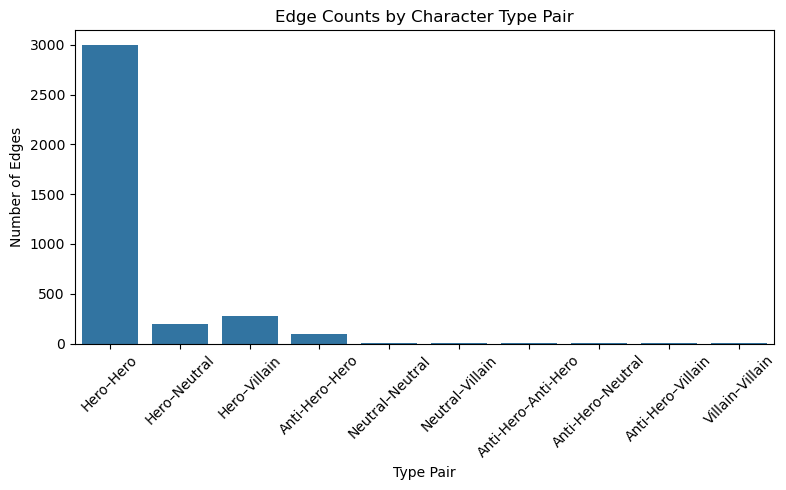

In [48]:
# Convert to DataFrame for plotting
df_edge_types = pd.DataFrame({
    'pair': [f"{a}–{b}" for a, b in edge_type_counts.keys()],
    'count': list(edge_type_counts.values())
})

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=df_edge_types, x='pair', y='count')
plt.title("Edge Counts by Character Type Pair")
plt.ylabel("Number of Edges")
plt.xlabel("Type Pair")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


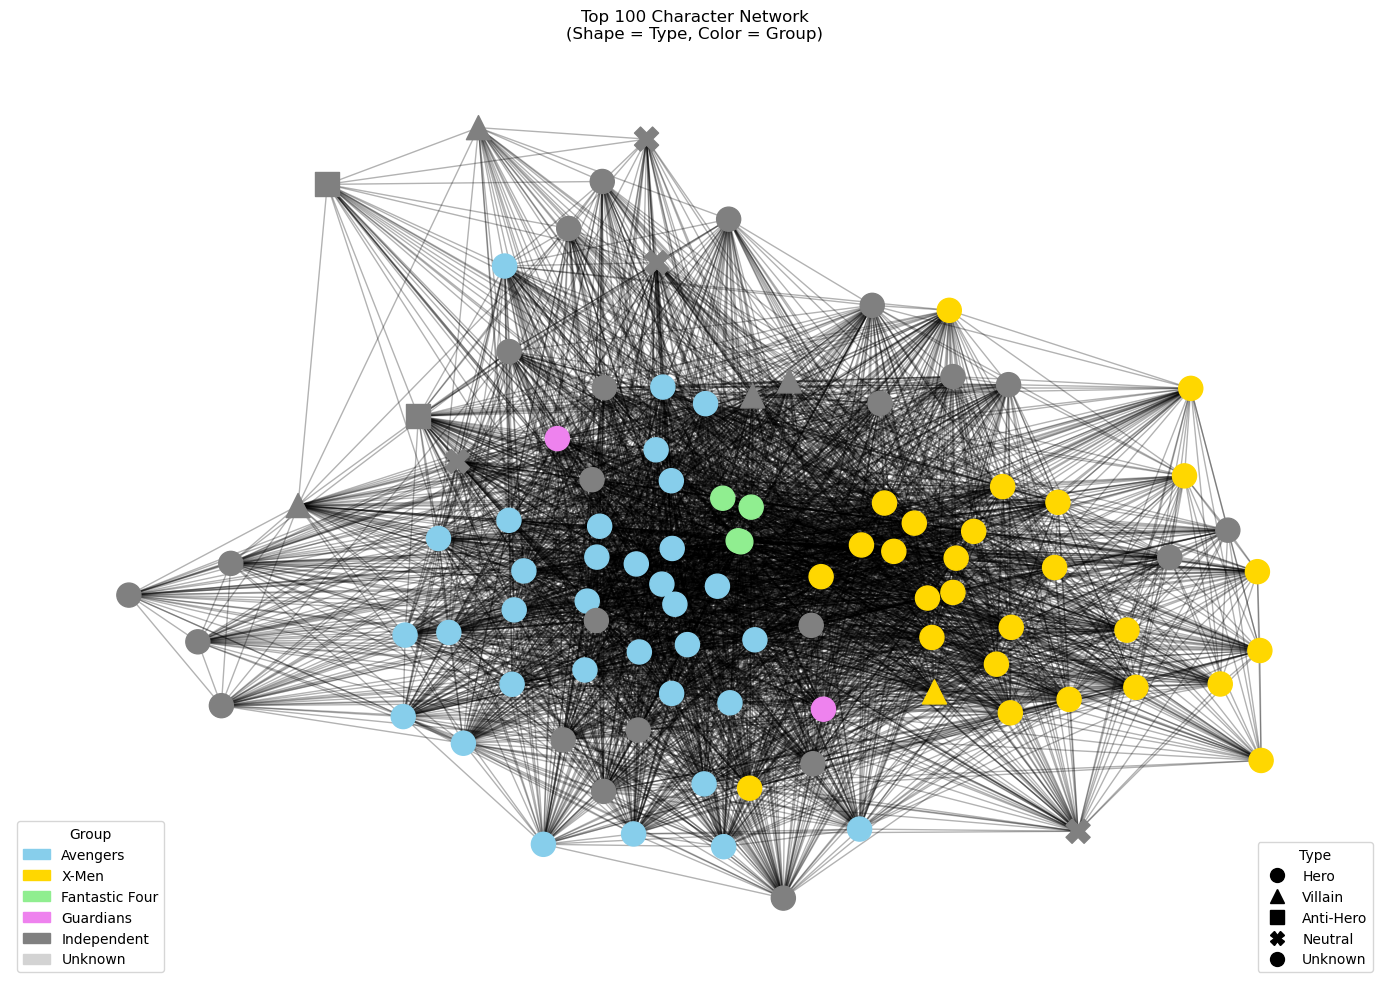

In [50]:
# Define colors for groups
group_colors = {
    'Avengers': 'skyblue',
    'X-Men': 'gold',
    'Fantastic Four': 'lightgreen',
    'Guardians': 'violet',
    'Independent': 'gray',
    'Unknown': 'lightgray'
}

# Define marker shapes for character types
type_shapes = {
    'Hero': 'o',        # circle
    'Villain': '^',     # triangle
    'Anti-Hero': 's',   # square
    'Neutral': 'X',
    'Unknown': 'o'
}

# Create layout for consistent spacing
pos = nx.spring_layout(G_top100, seed=42, k=0.25, weight='weight')

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

plt.figure(figsize=(14, 10))
nx.draw_networkx_edges(G_top100, pos, alpha=0.3)

# Draw nodes by type with color per group
for type_label, shape in type_shapes.items():
    nodes = [n for n, d in G_top100.nodes(data=True) if d.get('type') == type_label]
    node_colors = [group_colors.get(G_top100.nodes[n].get('group', 'Unknown'), 'lightgray') for n in nodes]
    
    nx.draw_networkx_nodes(
        G_top100, pos,
        nodelist=nodes,
        node_shape=shape,
        node_color=node_colors,
        node_size=300,
        label=type_label  # legend for type
    )

# Draw node labels optionally
# nx.draw_networkx_labels(G_top100, pos, font_size=8)

plt.title("Top 100 Character Network\n(Shape = Type, Color = Group)")
plt.axis('off')

# Create custom legends

# Legend for groups (colors)
group_patches = [mpatches.Patch(color=color, label=group) for group, color in group_colors.items()]

# Legend for types (shapes)
type_markers = {
    'Hero': 'o', 'Villain': '^', 'Anti-Hero': 's', 'Neutral': 'X', 'Unknown': 'o'
}
type_lines = [mlines.Line2D([], [], color='black', marker=marker, linestyle='None', markersize=10, label=type_)
              for type_, marker in type_markers.items()]

# Show both legends
legend1 = plt.legend(handles=group_patches, title="Group", loc='lower left')
plt.gca().add_artist(legend1)
plt.legend(handles=type_lines, title="Type", loc='lower right')

plt.tight_layout()
plt.show()


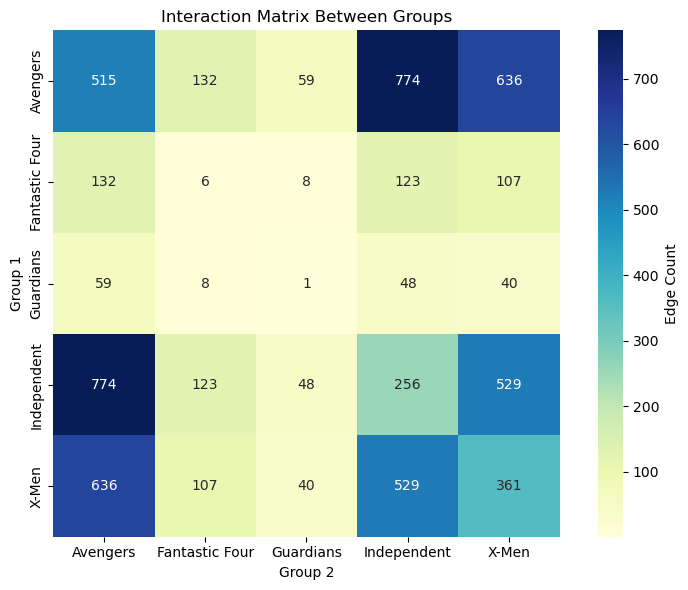

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Initialize group-pair counter
group_edges = defaultdict(int)

# Count edges between groups
for u, v in G_top100.edges():
    group_u = G_top100.nodes[u].get('group', 'Unknown')
    group_v = G_top100.nodes[v].get('group', 'Unknown')

    # Sort to count symmetric interactions (A–B same as B–A)
    g1, g2 = sorted([group_u, group_v])
    group_edges[(g1, g2)] += 1

# Convert to square matrix (DataFrame)
unique_groups = sorted(set(group for pair in group_edges for group in pair))
matrix = pd.DataFrame(0, index=unique_groups, columns=unique_groups)

for (g1, g2), count in group_edges.items():
    matrix.loc[g1, g2] = count
    matrix.loc[g2, g1] = count  # symmetric

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt="d", cmap="YlGnBu", square=True, cbar_kws={'label': 'Edge Count'})
plt.title("Interaction Matrix Between Groups")
plt.ylabel("Group 1")
plt.xlabel("Group 2")
plt.tight_layout()
plt.show()


In [52]:
from networkx.algorithms.community import greedy_modularity_communities

# Apply greedy modularity-based community detection
communities = list(greedy_modularity_communities(G_top100))

# Assign each node to a community number
community_map = {}
for i, community in enumerate(communities):
    for node in community:
        community_map[node] = i

# Set as node attribute for visualization
nx.set_node_attributes(G_top100, community_map, name="community")


In [53]:
# Create a dataframe with real group and detected community
df_compare = pd.DataFrame({
    "character": list(G_top100.nodes()),
    "group": [G_top100.nodes[n].get('group', 'Unknown') for n in G_top100.nodes()],
    "community": [G_top100.nodes[n]['community'] for n in G_top100.nodes()]
})

# Crosstab: group vs community → kaç kişi aynı kümeye düşmüş
ct = pd.crosstab(df_compare['group'], df_compare['community'])

print("Group vs Detected Community Matrix:")
print(ct)


Group vs Detected Community Matrix:
community        0   1
group                 
Avengers        29   4
Fantastic Four   2   2
Guardians        1   1
Independent     23  10
X-Men            0  28


C:\Users\fatihonur\AppData\Local\Temp\ipykernel_24244\3293448121.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', num_communities)


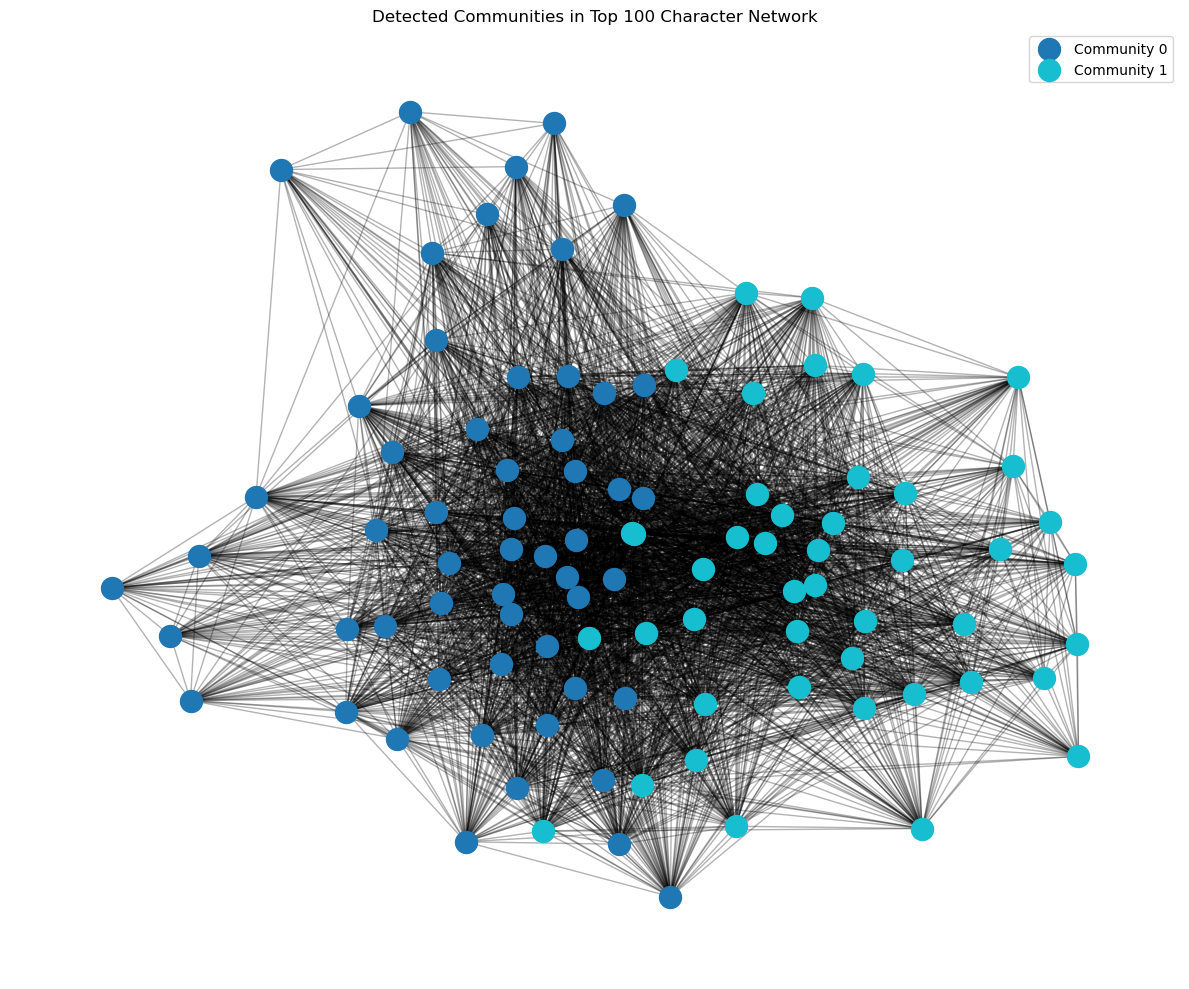

In [54]:
import matplotlib.pyplot as plt

# Choose a color per community
import matplotlib.cm as cm
num_communities = len(communities)
colors = cm.get_cmap('tab10', num_communities)

# Draw graph
pos = nx.spring_layout(G_top100, seed=42, k=0.25)

plt.figure(figsize=(12, 10))
nx.draw_networkx_edges(G_top100, pos, alpha=0.3)

for i in range(num_communities):
    members = [n for n in G_top100.nodes() if G_top100.nodes[n]['community'] == i]
    nx.draw_networkx_nodes(
        G_top100, pos,
        nodelist=members,
        node_color=[colors(i)],
        label=f"Community {i}",
        node_size=250
    )

plt.title("Detected Communities in Top 100 Character Network")
plt.axis('off')
plt.legend()
plt.tight_layout()
plt.show()
